---

## A - OFDM Python Lab

Following on from the lectures and the previous notebooks on the fundamental properties of OFDM, the goal of this lab is to understand and implement the OFDM physical layer.

You are provided with an OFDM signal coming from a multipath, noisy channel that we have received (<code>homework_x.npy</code>) in the lab and need to implement the receiver part of OFDM modem.

For this, you will need to implement the following RX signal chain :

* Cyclic Prefix Removal  
* Fast Fourrier Transform (FFT)
* Channel Estimation
* Equalization
* Data decoding


---


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import helper_functions as hf

Let's start by opening our homework assignment

In [2]:
rx_signal = np.load('homework11.npy')

Let's start by defining the basic parameters of our lab, that you will need to use all along the signal chain, which are also known to the transmitter:

In [3]:
fs = 20e6 # Sampling rate 
N = 64 # No. of sub-carriers 
n_data = 52 # No. of data sub-carriers
cp_len = 16 # No. of cyclic prefix samples
n_ofdm = 1000 # No. of OFDM symbols
nsym = n_ofdm * n_data # No. of data symbols

In [4]:
# The preamble bits are used for channel estimation and are known to both the transmitter and the receiver
preamble_bits = np.array([0,0,0,0,0,0,1,1,-1,\
                  -1,1,1,-1,1,-1,1,1,1,\
                  1,1,1,-1,-1,1,1,-1,1,\
                  -1,1,1,1,1,0,1,-1,-1,\
                  1,1,-1,1,-1,1,-1,-1,\
                  -1,-1,-1,1,1,-1,-1,1,\
                  -1,1,-1,1,1,1,1,0,0,0,\
                  0,0])

We will start by extracting the preamble symbols and demodulating them using the FFT. These will be used for channel estimation purposes. In this example, we know the exact timing of the beginning of each symbol. However, in practice, this is unknown and an appropriate timing synchronisation algorithm must be used to acquire symbol timing. Also, due to oscillator offsets between transmitter and receiver and Doppler effects, a frequency synchronisation stage must be performed prior to the FFT in order to minimise the potential for Inter Carrier Interference (ICI).  

The beginning of the first preamble OFDM symbol is sample 33 i.e. immediately after the 32 sample CP, and of the 2nd one is at 96; each one being of length 64:

In [5]:
# Extract received preamble OFDM symbols 
rx_preamble_symb_1 = rx_signal[32:96]

rx_preamble_symb_2 = rx_signal[96:160]

Now, let's take the FFT of each preamble in order to recover the transmitted sequence:

In [6]:
preamble_symb_demod_1 = np.fft.fftshift(np.fft.fft(rx_preamble_symb_1,N))
preamble_symb_demod_2 = np.fft.fftshift(np.fft.fft(rx_preamble_symb_2,N))

As mentionned previously, in the variables of the lab, there will be 52 data sub-carriers. Nonetheless, and as you have seen during th lectures, not all data subcarriers are usable: in our case, we will choose to elimnate the DC subcarrier bin, and keep a number of 6 guard subcarriers, allowing us to minimise interference with other signals.

In [7]:
# Indices for data sub-carriers (Guard/Unused Subcarriers)
ind_1 = np.arange(start=6, stop=32)
ind_2 = np.arange(start=33, stop=59)
index = np.concatenate((ind_1, ind_2), axis=0)

We'll leave these here for now and return to them when we do channel estimation. <br> Now let's extract the data payload OFDM symbols and perform FFTs to recover the underlying data symbols. The CP is removed because it does not contain any information.

In [8]:
# Function to demodulate OFDM 
def ofdm_demod(ofdm_rx,N,cp_len):
    
    # Remove CP 
    ofdm_u = ofdm_rx[cp_len:(N+cp_len)]
    
    # Perform FFT 
    data = np.fft.fftshift(np.fft.fft(ofdm_u,N))
    
    return data

# Array to hold recovered  data symbols  
data_rx = np.zeros(n_ofdm*n_data,np.complex64)
j = 0
k = 0 

# Extract data payload (after end of L-LTF)
L = len(rx_signal)
rxPayload = rx_signal[160:L:1]

# Demodulate OFDM symbols in payload 
for i in range(n_ofdm):
    
    # Demodulate OFDM symbols 
    rx_demod = ofdm_demod(rxPayload[k:(k+N+cp_len)],N,cp_len)
    
    # Extract data symbols 
    data_rx[j:j+n_data] = rx_demod[index] 
    
    j = j + n_data
    k = k + N + cp_len 

### 4.1. Channel Estimation <a class="anchor" id="chanest"></a>

At this stage, we will perform channel estimation. Recall that the channel effect is reduced to a single complex multiplication per sub-carrier. The received symbol on sub-carrier $k$, $Y[k]$, in any given OFDM symbol is given by:    

$$ Y[k] = H[k]X[k] + W[k],$$

where $X[k]$ is the $k^{th}$ transmitted data symbol, $H[k]$ is the frequency response at sub-carrier $k$ and $W[k]$ is the noise at sub-carrier $k$.  

The data symbols transmitted in the preamble symbols are known to the receiver. Therefore, we can estimate the channel by dividing through by $X[k]$, leading to:

$$ \hat{H}[k] = \frac{Y[k]}{X[k]} = H[k] + \frac{W[k]}{X[k]} = H[k] + \alpha_{k}, $$

where $\hat{H}[k]$ is the $k^{th}$ channel estimate. The quantity $W[k]/X[k]$ is an unwanted noise term which we denote as $\alpha_{k}$. Since we have two OFDM symbols in the preamble, we can generate two channel estimates. Let's extract the symbols on the data sub-carriers, since the null sub-carriers don't carry any information:

In [9]:
# Extract data sub-carriers
data_subcarrier_1 = preamble_symb_demod_1[index]
data_subcarrier_2 = preamble_symb_demod_2[index] 

In [10]:
# Get channel estimates 
h_1 = data_subcarrier_1 / preamble_bits[index]
h_2 = data_subcarrier_2 / preamble_bits[index]

Since the channel effect is not changing over time (in this simplified case), we can average $h_{1}$ and $h_{2}$ to produce a final channel estimate:

In [11]:
# Average h_1 and h_2 to get final estimate 
h_final = (h_1 + h_2) / 2

### Channel Equalisation <a class="anchor" id="chaneq"></a>

In OFDM, there are two common equalisation methods; the one-tap or Zero Forcing (ZF) equaliser and the Minimum Mean Square Error (MMSE) equaliser. At this stage, we will restrict our discussion to the ZF equaliser.

The one-tap or ZF equaliser is the most computationally efficient equalisation method. It is given by: 

$$ \hat{X}[k] = \frac{Y[k]}{\hat{H}[k]}. $$

Before expanding the above equation, let's assume that sufficient time averaging of channel estimates has been performed such that $\alpha_{k} = 0$. This will simplify the expanded expression. Therefore, we arrive at:

$$ \hat{X}[k] = \frac{Y[k]}{\hat{H}[k]} = \frac{X[k]H[k] + W[k]}{H[k]} = X[k] + \frac{W[k]}{H[k]}.$$

Inspecting the above, we see that the equalised symbol includes an error term, $W[k]/H[k]$. This error term has a detrimental effect on the performance of the ZF equaliser because when $|H[k]|$ is close to zero, i.e. when the channel is in a deep fade, the $W[k]$ or noise term is amplified. Moreover, as the noise power increases, the amplification has a more severe effect. These issues lead to an SNR degradation after the ZF equaliser.

Based on the procedure for complex division, the ZF equaliser can be re-written as:

$$ \hat{X}[k] = Y[k]\frac{\hat{H}^{*}[k]}{|\hat{H}[k]|^{2}}, $$

where * denotes complex conjugation. The term $\frac{\hat{H}^{*}[k]}{|\hat{H}[k]|^{2}}$ is referred to as the ZF equaliser gain. 

Let's now inspect the received constellation before applying the ZF equaliser.  

<Axes: title={'center': 'Constellation plot'}, xlabel='Channel 1 amplitude', ylabel='Channel 2 amplitude'>

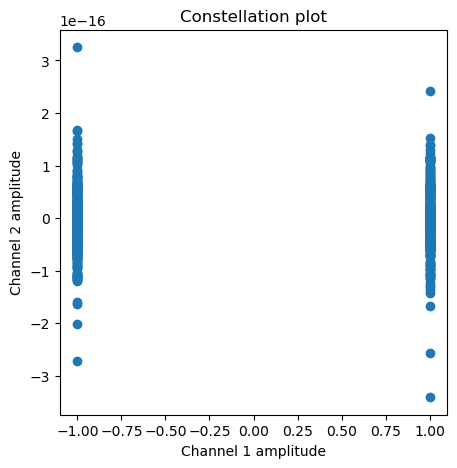

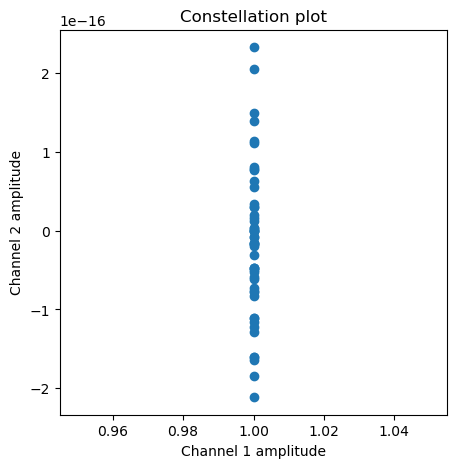

In [12]:
# Plot constellation 
hf.scatterplot(data_rx.real,data_rx.imag,ax=None)
hf.scatterplot(h_final.real,h_final.imag,ax=None)

It is clear that the received constellations are heavily distorted. Without equalisation, this would lead to a large number of symbol and bit errors. In the next cell, we will equalise the data symbols using the channel estimate from the previous section:

In [13]:
# Equalise data symbols 
data_eq_zf = np.zeros(n_ofdm*n_data,np.complex64)
j = 0

for i in range (n_ofdm):
    
    data_eq_zf[j:j+n_data] = data_rx[j:j+n_data] * (np.conj(h_final)/abs(h_final)**2)
    
    j = j + n_data

<Axes: title={'center': 'Constellation plot'}, xlabel='Channel 1 amplitude', ylabel='Channel 2 amplitude'>

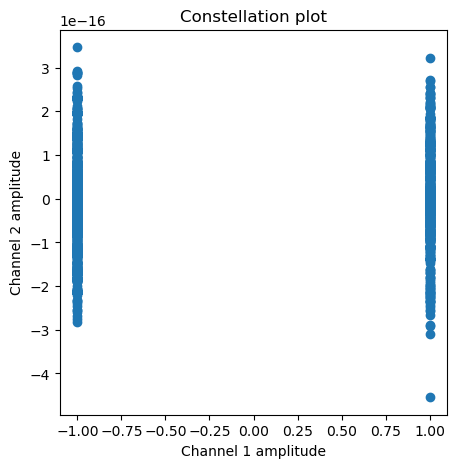

In [14]:
# Plot constellation 
#hf.scatterplot(data_eq_zf.real,data_eq_zf.imag,ax=None)
hf.scatterplot(data_eq_zf.real,data_eq_zf.imag,ax=None)

Now, it's time to demap and then demodulate the data symbols we obtained using BPSK: first, implement a simple hard-decision demapper for BPSK symbols (the previous constellation plot might be useful in determining a good threshold); you are free to come-up with your own demapper!

In [15]:
# Function to demodulate BPSK back to UTF-8 characters
def bpsk_demodulate_text(symbols):
    data = np.array([])
    for symbol in symbols:
        if symbol < 0:
            data = np.append(data, 0)
        else :
            data = np.append(data, 1)
            
    return data

It is now time to decode the final message that you will need to send on Moodle.

In [16]:
text_bits = bpsk_demodulate_text(data_rx)

We then provide you with a small piece of code which takes a Numpy array of floating-point 1 or 0s and converts it to their respective UTF-8 characters.

In [17]:
text_bits = text_bits.astype(int)
byte_array = np.packbits(text_bits)

utf8_string = byte_array.tobytes().decode('utf-8')

print(utf8_string)

Congratulations on completing the OFDM lab! OFDM is an amazing technology with numerous applications, did you know that MIMO (Multiple Input Multiple Output) is often combined with OFDM for enhanced performance.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     